In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import math
import os
import random
from pathlib import Path
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False


%load_ext pycodestyle_magic
%pycodestyle_on --ignore E501

time: 1.84 s (started: 2022-09-04 03:47:44 +00:00)


# Prepare data

In [3]:
data_implement = "sp500"  # tw50|sp500|tetuan_power
dataset_path = Path("./dataset/")
if data_implement == "tw50":
    file_name = Path("tw50_hold_20082018_adj_close_pre.csv")
    train_set = ['萬海_adj_close', '豐泰_adj_close', '友達_adj_close', '欣興_adj_close', '台塑化_adj_close', '和泰車_adj_close', '元大金_adj_close', '南電_adj_close', '台塑_adj_close', '統一超_adj_close', '台泥_adj_close', '瑞昱_adj_close', '彰銀_adj_close', '富邦金_adj_close', '研華_adj_close', '中鋼_adj_close', '鴻海_adj_close', '台新金_adj_close', '遠傳_adj_close', '南亞_adj_close', '台達電_adj_close', '台灣大_adj_close', '台化_adj_close', '聯詠_adj_close', '廣達_adj_close', '聯發科_adj_close', '台積電_adj_close', '統一_adj_close', '中信金_adj_close', '長榮_adj_close']
elif data_implement == "sp500":
    file_name = Path("sp500_hold_19972007_adj_close_pre.csv")
    train_set = ['PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'NEM', 'CTAS', 'MAT', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'CI', 'ZION', 'COO', 'FDX', 'GLW', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'BMY', 'KMB', 'JPM', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'WMB', 'IFF', 'CMS', 'MMC', 'REG', 'ES', 'ITW', 'VRTX', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'VNO', 'WDC', 'PVH', 'NOC', 'PCAR', 'NSC', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'ALK', 'TAP', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'HIG', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'CMA', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG']
elif data_implement == "tetuan_power":
    file_name = Path("Tetuan City power consumption_pre.csv")
    train_set = ["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows", "Zone 1 Power Consumption", "Zone 2 Power Consumption", "Zone 3 Power Consumption"]

dataset_df = pd.read_csv(dataset_path/file_name)
dataset_df = dataset_df.set_index('Date')
all_set = list(dataset_df.columns.values[1:]) # all data
test_set = [p for p in all_set if p not in train_set] # all data - train data
print(f"len(train_set): {len(train_set)}, len(all_set): {len(all_set)}, len(test_set): {len(test_set)}")

# setting of output files
save_raw_corr_data = True
save_arima_resid_data = True
time_period = "_test2"

eva_setting = "all"
if eva_setting == "all": # evaluation set
    eva_set = all_set
    output_set_name = "_all"
elif eva_setting == "test":
    eva_set = test_set
    output_set_name = "_test"

lstm_weight_setting = "tetuan_power"  # tw50|sp500|tetuan_power
if lstm_weight_setting == "sp500": # lstm weight set
    lstm_weight_filepath =  "../rebuild_hybrid_model/models/20220807/epoch_582.h5"
    lstm_weight_name = "_sp500LSTM"
elif lstm_weight_setting == "tw50":
    lstm_weight_filepath = "./models/20220816/tw50_20082017_epoch_246.h5"
    lstm_weight_name = "_tw50LSTM"
elif lstm_weight_setting == "tetuan_power":
    lstm_weight_filepath = "./models/20220831/tetuan_power_res_epoch_597.h5"
    lstm_weight_name = "_tetuan_powerLSTM"

evaluation_info = {"paper_eva_1": {"items": ['PRGO', 'MRO', 'ADP', 'HCP', 'FITB', 'PEG', 'SYMC', 'EOG', 'MDT', 'NI'], "file_name": "paper_eva_1_res"},
                   "paper_eva_2": {"items": ['STI', 'COP', 'MCD', 'AON', 'JBHT', 'DISH', 'GS', 'LRCX', 'CTXS', 'LEG'], "file_name": "paper_eva_2_res"},
                   "paper_eva_3": {"items": ['TJX', 'EMN', 'JCI', 'C', 'BIIB', 'HOG', 'PX', 'PH', 'XEC', 'JEC'], "file_name": "paper_eva_3_res"},
                   "paper_eva_4": {"items": ['ROP', 'AZO', 'URI', 'TROW', 'CMCSA', 'SLB', 'VZ', 'MAC', 'ADS', 'MCK'], "file_name": "paper_eva_4_res"},
                   "paper_eva_5": {"items": ['RL', 'CVX', 'SRE', 'PFE', 'PCG', 'UTX', 'NTRS', 'INCY', 'COP', 'HRL'], "file_name": "paper_eva_5_res"},
                   "tw50": {"items": eva_set, "file_name": f"tw50_20082017_res"},
                   "sp500": {"items": eva_set, "file_name": f"sp500_19972007_res"},
                   "tetuan_power": {"items": eva_set, "file_name":  f"tetuan_power_res"}}

items_implement = evaluation_info[data_implement]['items']
output_file_name = evaluation_info[data_implement]['file_name'] + output_set_name + time_period + lstm_weight_name
fig_title = data_implement + output_set_name + time_period + lstm_weight_name



# display(dataset_df)
# display(all_set)

5:80: E501 line too long (507 > 79 characters)
8:80: E501 line too long (769 > 79 characters)
11:80: E501 line too long (183 > 79 characters)
15:46: E261 at least two spaces before inline comment
16:54: E261 at least two spaces before inline comment
17:80: E501 line too long (104 > 79 characters)
25:25: E261 at least two spaces before inline comment
33:35: E261 at least two spaces before inline comment
34:27: E222 multiple spaces after operator
34:80: E501 line too long (82 > 79 characters)
43:80: E501 line too long (150 > 79 characters)
44:80: E501 line too long (151 > 79 characters)
45:80: E501 line too long (145 > 79 characters)
46:80: E501 line too long (150 > 79 characters)
47:80: E501 line too long (149 > 79 characters)
48:80: E501 line too long (81 > 79 characters)
49:80: E501 line too long (83 > 79 characters)
50:80: E501 line too long (89 > 79 characters)
53:80: E501 line too long (114 > 79 characters)
58:1: E303 too many blank lines (3)


len(train_set): 108, len(all_set): 326, len(test_set): 218
time: 91.6 ms (started: 2022-09-04 03:47:46 +00:00)


In [4]:
def gen_unseen_data_corr(items: list, time_period:str = "_test2", ret_date: bool = False) -> "pd.DataFrame, pd.Series | pd.DataFrame":
    tmp_corr = dataset_df[items[0]].rolling(window=100).corr(dataset_df[items[1]])
    tmp_corr = tmp_corr.iloc[99::100]
    if time_period == "_test2":
        corr_series = tmp_corr[3:24] # correspond to test2_dataset of original paper
    elif time_period == "_test1" :
        corr_series = tmp_corr[2:23] # correspond to test1_dataset of original paper
    elif time_period == "_dev":
        corr_series = tmp_corr[1:22] # correspond to dev_dataset of original paper
    elif time_period == "_train":
        corr_series = tmp_corr[:21] # correspond to train_dataset of original papaer 
    unseen_data_df = pd.DataFrame(corr_series).reset_index().drop(['Date'], axis=1).T
    if ret_date:
        return unseen_data_df, corr_series
    else:
        return unseen_data_df

ValueError: too many values to unpack (expected 3)

time: 778 µs (started: 2022-09-04 03:47:48 +00:00)


In [6]:
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test2"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test1"))
display(gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_dev"))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.567311,0.790411,0.244315,0.706132,-0.185338,0.810525,-0.269763,-0.580017,0.559902,0.621843,...,0.085289,0.676401,0.403053,0.62385,0.617948,-0.859602,0.724252,0.521488,0.823675,0.136373


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.055313,0.567311,0.790411,0.244315,0.706132,-0.185338,0.810525,-0.269763,-0.580017,0.559902,...,0.851445,0.085289,0.676401,0.403053,0.62385,0.617948,-0.859602,0.724252,0.521488,0.823675


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.45781,-0.055313,0.567311,0.790411,0.244315,0.706132,-0.185338,0.810525,-0.269763,-0.580017,...,0.621843,0.851445,0.085289,0.676401,0.403053,0.62385,0.617948,-0.859602,0.724252,0.521488


1:80: E501 line too long (93 > 79 characters)
2:80: E501 line too long (93 > 79 characters)
3:80: E501 line too long (91 > 79 characters)


# ARIMA model

In [8]:
def arima_model(dataset: "pd.DataFrame", items: list, overview: bool = False) -> ("np.array", "pd.DataFrame", str):
    model_110 = ARIMA(order=(1, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_011 = ARIMA(order=(0, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_111 = ARIMA(order=(1, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_211 = ARIMA(order=(2, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_210 = ARIMA(order=(2, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    #model_330 = ARIMA(order=(3, 3, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)

    #model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
    model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}

    tested_models = []
    arima_model = None
    find_arima_model = False
    residual = []
    for s in np.array(dataset):
        while not find_arima_model:
            try:
                for model_key in model_dict:
                    if model_key not in tested_models:
                        test_model = model_dict[model_key].fit(s)
                        if arima_model is None:
                            arima_model = test_model
                            arima_model_name = model_key
                        elif arima_model.aic() <= test_model.aic():
                            pass
                        else:
                            arima_model = test_model
                            arima_model_name = model_key
                    tested_models.append(model_key)

            except Exception:
                if len(model_dict)-1 != 0:
                    del model_dict[model_key]
                else:
                    print(f"fatal error, {items} doesn't have appropriate arima model")
                    break
            else:
                #model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
                model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}
                tested_models.clear()
                find_arima_model = True

        arima_pred = list(arima_model.predict_in_sample())
        arima_pred = [np.mean(arima_pred[1:])] + arima_pred[1:]
        arima_pred = np.clip(np.array(arima_pred), -1, 1)

        res = pd.Series(np.array(s) - arima_pred)
        residual.append(np.array(res)[:20])
        find_arima_model = False
    residual = pd.DataFrame(residual)

    if overview:
        plt.plot(arima_pred, label="arima_pred")
        plt.plot(dataset.T, label="data")
        plt.plot(res, label="res")
        plt.legend()
        plt.show()
        plt.close()

    return arima_pred, residual, arima_model_name

1:80: E501 line too long (115 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
3:80: E501 line too long (105 > 79 characters)
4:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)
7:5: E265 block comment should start with '# '
7:80: E501 line too long (106 > 79 characters)
9:5: E265 block comment should start with '# '
9:80: E501 line too long (162 > 79 characters)
10:80: E501 line too long (137 > 79 characters)
36:80: E501 line too long (87 > 79 characters)
39:17: E265 block comment should start with '# '
39:80: E501 line too long (174 > 79 characters)
40:80: E501 line too long (149 > 79 characters)


In [14]:
unseen_data_corr_df = gen_unseen_data_corr([items_implement[0], items_implement[1]], time_period="_test2")
arima_pred, residual, arima_model_name = arima_model(unseen_data_corr_df.iloc[::, :-1], [items_implement[0], items_implement[1]])
display(len(arima_pred))
display(arima_pred)
arima_pred, residual, arima_model_name = arima_model(unseen_data_corr_df, [items_implement[0], items_implement[1]])
display(len(arima_pred))
display(arima_pred)

20

array([0.43070105, 0.57038611, 0.6834742 , 0.54016308, 0.58473129,
       0.43379155, 0.49965715, 0.39281333, 0.27428171, 0.30909415,
       0.34344622, 0.39270627, 0.37016207, 0.39679652, 0.40031916,
       0.41829856, 0.43385393, 0.360833  , 0.38410194, 0.3944098 ])

21

array([0.40901078, 0.5667159 , 0.67796881, 0.53282291, 0.57555577,
       0.42278205, 0.48681165, 0.37813445, 0.25777009, 0.29074608,
       0.32326168, 0.37068452, 0.34630661, 0.37110447, 0.37279206,
       0.3889352 , 0.40265444, 0.32780682, 0.34923796, 0.35770965,
       0.38041459])

1:80: E501 line too long (106 > 79 characters)
2:80: E501 line too long (129 > 79 characters)
5:80: E501 line too long (115 > 79 characters)


# LSTM

In [6]:
class DoubleTanh(Activation):
    def __init__(self, activation, **kwargs):
        super(DoubleTanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'


def double_tanh(x):
    return (K.tanh(x) * 2)


# get_custom_objects().update({'double_tanh': DoubleTanh(double_tanh)})

# filepath = './stock_correlation_prediction/models/hybrid_LSTM_20220427/epoch262.h5'
# custom_objects = {"Double_Tanh": DoubleTanh, }
# with keras.utils.custom_object_scope(custom_objects):
#     lstm_model = load_model(filepath)

lstm_model = load_model(lstm_weight_filepath, custom_objects={'double_tanh':double_tanh})

2022-09-02 04:18:31.509395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 04:18:31.514120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 04:18:31.514340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 04:18:31.514866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

ValueError: too many values to unpack (expected 3)

# Hybrid model

In [7]:
def stl_decompn(corr_series: "pd.Series", overview: bool = False) -> (float, float, float):
    output_resid = 100000
    output_trend = None
    output_period = None
    for p in range(2, 11):
        decompose_result_mult = seasonal_decompose(corr_series, period=p)
        resid_sum = np.abs(decompose_result_mult.resid).mean()
        if output_resid > resid_sum:
            output_resid = resid_sum
            output_trend = decompose_result_mult.trend.dropna()
            output_period = p
    
    reg = LinearRegression().fit(np.arange(len(output_trend)).reshape(-1, 1), output_trend)

    if overview:
        decompose_result_mult = seasonal_decompose(corr_series, period=output_period)
        trend = decompose_result_mult.trend.dropna().reset_index(drop=True)
        plt.figure(figsize=(7, 1))
        plt.plot(trend)
        plt.plot([0, len(trend)], [reg.intercept_, reg.intercept_+len(trend)*reg.coef_])
        plt.title("trend & regression line")
        plt.show()
        plt.close()
        decompose_result_mult.plot()
        plt.show()
        plt.close()

    return output_period, output_resid, output_trend.std(), reg.coef_[0]

1:80: E501 line too long (91 > 79 characters)
12:1: W293 blank line contains whitespace
13:80: E501 line too long (91 > 79 characters)
16:80: E501 line too long (85 > 79 characters)
20:80: E501 line too long (88 > 79 characters)


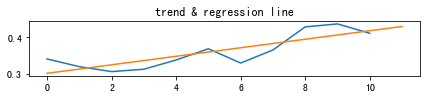

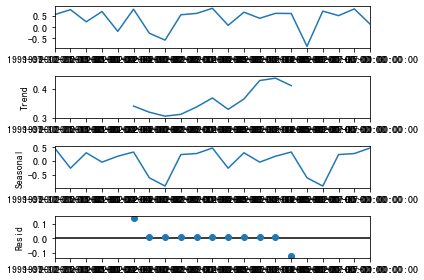

(10, 0.03255243627684664, 0.04676361180730613, 0.011673242575461857)

1:80: E501 line too long (124 > 79 characters)


In [8]:
unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr([items_implement[0], items_implement[1]], ret_date=True)
stl_decompn(unseen_data_corr_series, overview=True)

In [9]:
res_list = []
unseen_data_corr_df_concat = pd.DataFrame(columns=list(range(21))+['items'])
unseen_data_arima_resid_concat = pd.DataFrame(columns=list(range(20))+['items'])
count = 0
for items in tqdm(combinations(items_implement, 2)):
    unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(items, time_period=time_period, ret_date=True)
    arima_pred, residual, arima_model_name = arima_model(unseen_data_corr_df, items)
    unseen_res = residual.values.reshape((-1, 20, 1))
    lstm_pred = lstm_model.predict(unseen_res)
    season_period, stl_resid, stl_trend_std, coef_reg_trend = stl_decompn(unseen_data_corr_series)
    items_res_dic = {"items": f"{items[0]} & {items[1]}",
                         "corr_ser_mean": unseen_data_corr_series.mean(),
                         "corr_ser_std": unseen_data_corr_series.std(),
                         "corr_season_period": season_period,
                         "corr_stl_resid": stl_resid,
                         "corr_stl_trend_std": stl_trend_std,
                         "corr_trend_coef": coef_reg_trend,
                         "arima_model": arima_model_name,
                         "lstm_pred": lstm_pred[0][0],
                         "arima_pred": arima_pred[-1],
                         "hybrid_model_pred": arima_pred[-1]+lstm_pred[0][0],
                         "ground_truth": unseen_data_corr_df.iloc[0, -1],
                         "arima_err": unseen_data_corr_df.iloc[0, -1] - arima_pred[-1],
                         "error": (unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])),
                         "absolute_err": math.copysign((unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])), 1), 
                         "lstm_compensation_dir": np.sign(unseen_data_corr_df.iloc[0, -1] - arima_pred[-1])*np.sign(lstm_pred[0][0])}

    res_list.append(items_res_dic)
    unseen_data_corr_df['items'] = f"{items[0]} & {items[1]}"
    unseen_data_corr_df_concat = pd.concat([unseen_data_corr_df_concat, unseen_data_corr_df]) 
    residual['items'] = f"{items[0]} & {items[1]}"
    unseen_data_arima_resid_concat = pd.concat([unseen_data_arima_resid_concat, residual]) 

if save_raw_corr_data:
    unseen_data_corr_df_concat = unseen_data_corr_df_concat.set_index('items')
    unseen_data_corr_df_concat.to_csv(f"./results/{output_file_name}_raw_corr.csv", index=True)
    
if save_arima_resid_data:
    unseen_data_arima_resid_concat = unseen_data_arima_resid_concat.set_index('items')
    unseen_data_arima_resid_concat.to_csv(f"./results/{output_file_name}_arima_resid.csv", index=True)

0it [00:00, ?it/s]2022-09-02 04:18:33.511033: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
52975it [2:59:16,  4.92it/s]
3:80: E501 line too long (80 > 79 characters)
6:80: E501 line too long (118 > 79 characters)
7:80: E501 line too long (84 > 79 characters)
10:80: E501 line too long (98 > 79 characters)
12:26: E127 continuation line over-indented for visual indent
23:80: E501 line too long (87 > 79 characters)
24:80: E501 line too long (103 > 79 characters)
25:80: E501 line too long (128 > 79 characters)
25:129: W291 trailing whitespace
26:80: E501 line too long (133 > 79 characters)
30:80: E501 line too long (93 > 79 characters)
30:94: W291 trailing whitespace
32:80: E501 line too long (90 > 79 characters)
32:91: W291 trailing whitespace
36:80: E501 line too long (95 > 79 characters)
37:1: W293 blank line contains whitespace
39:80: E501 line too long (86 > 79 characters)
40:80: E501 line too long (102 > 79 characters)


In [10]:
res_df = pd.DataFrame(res_list)
res_df.to_csv(f"./results/{output_file_name}.csv", index=False)

# Display results

In [11]:
res_df = pd.read_csv(f"./results/{output_file_name}.csv")
display(res_df)

,items,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,arima_model,lstm_pred,arima_pred,hybrid_model_pred,ground_truth,arima_err,error,absolute_err,lstm_compensation_dir
0,ABC & ABT,0.374738,0.485401,10,0.032552,0.046764,0.011673,model_011,-0.042838,0.380415,0.337577,0.136373,-0.244042,-0.201204,0.201204,1.0
1,ABC & ADBE,-0.005009,0.552578,9,0.088579,0.080956,0.016569,model_111,-0.312793,0.473902,0.161110,0.099753,-0.374150,-0.061357,0.061357,1.0
2,ABC & ADI,-0.061380,0.525496,10,0.017628,0.120391,0.033365,model_210,-0.023890,0.060168,0.036278,-0.469325,-0.529492,-0.505603,0.505603,1.0
3,ABC & ADM,0.269723,0.497793,10,0.086895,0.073934,0.016151,model_211,-0.234381,0.733919,0.499539,0.453906,-0.280013,-0.045632,0.045632,1.0
4,ABC & ADP,0.081505,0.569501,10,0.094837,0.081937,0.021299,model_011,-0.626505,0.299517,-0.326988,-0.612767,-0.912283,-0.285779,0.285779,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52970,XRAY & YUM,0.302496,0.443629,7,0.109566,0.169532,-0.011442,model_110,0.886467,0.096126,0.982593,0.908636,0.812510,-0.073957,0.073957,1.0
52971,XRAY & ZION,0.152196,0.533865,10,0.059169,0.070685,0.017592,model_210,0.052632,0.247345,0.299976,-0.837512,-1.084856,-1.137488,1.137488,-1.0
52972,XRX & YUM,0.222535,0.448983,10,0.107532,0.055258,0.014114,model_011,0.394212,0.352963,0.747175,0.876442,0.523479,0.129267,0.129267,1.0
52973,XRX & ZION,0.128015,0.567873,8,0.111673,0.171195,0.016481,model_211,-0.203846,-0.030303,-0.234149,-0.725434,-0.695131,-0.491285,0.491285,1.0


In [12]:
def res_df_postprocess(target_df: pd.core.frame.DataFrame) -> None:
    target_df['arima_pred_dir'] = np.sign(target_df['ground_truth'] * target_df['arima_pred'])
    target_df['arima_err'] = target_df['ground_truth'] - target_df['arima_pred']
    quantile_mask = np.logical_and(res_df['error'] < np.quantile(res_df['error'], 0.75), res_df['error'] > np.quantile(res_df['error'], 0.25)).tolist()
    display(np.quantile(res_df['error'], 0.75), np.quantile(res_df['error'], 0.25))
    target_df['high_pred_performance'] = quantile_mask
    target_df['items[0]'] = target_df.apply(lambda row:row['items'].split(" & ")[0], axis=1)
    target_df['items[1]'] = target_df.apply(lambda row:row['items'].split(" & ")[1], axis=1)


res_df_postprocess(res_df)
display(res_df)

0.13433957525449336

-0.19291267164251397

,items,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,arima_model,lstm_pred,arima_pred,hybrid_model_pred,ground_truth,arima_err,error,absolute_err,lstm_compensation_dir,arima_pred_dir,high_pred_performance,items[0],items[1]
0,ABC & ABT,0.374738,0.485401,10,0.032552,0.046764,0.011673,model_011,-0.042838,0.380415,0.337577,0.136373,-0.244042,-0.201204,0.201204,1.0,1.0,False,ABC,ABT
1,ABC & ADBE,-0.005009,0.552578,9,0.088579,0.080956,0.016569,model_111,-0.312793,0.473902,0.161110,0.099753,-0.374150,-0.061357,0.061357,1.0,1.0,True,ABC,ADBE
2,ABC & ADI,-0.061380,0.525496,10,0.017628,0.120391,0.033365,model_210,-0.023890,0.060168,0.036278,-0.469325,-0.529492,-0.505603,0.505603,1.0,-1.0,False,ABC,ADI
3,ABC & ADM,0.269723,0.497793,10,0.086895,0.073934,0.016151,model_211,-0.234381,0.733919,0.499539,0.453906,-0.280013,-0.045632,0.045632,1.0,1.0,True,ABC,ADM
4,ABC & ADP,0.081505,0.569501,10,0.094837,0.081937,0.021299,model_011,-0.626505,0.299517,-0.326988,-0.612767,-0.912283,-0.285779,0.285779,1.0,-1.0,False,ABC,ADP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52970,XRAY & YUM,0.302496,0.443629,7,0.109566,0.169532,-0.011442,model_110,0.886467,0.096126,0.982593,0.908636,0.812510,-0.073957,0.073957,1.0,1.0,True,XRAY,YUM
52971,XRAY & ZION,0.152196,0.533865,10,0.059169,0.070685,0.017592,model_210,0.052632,0.247345,0.299976,-0.837512,-1.084856,-1.137488,1.137488,-1.0,-1.0,False,XRAY,ZION
52972,XRX & YUM,0.222535,0.448983,10,0.107532,0.055258,0.014114,model_011,0.394212,0.352963,0.747175,0.876442,0.523479,0.129267,0.129267,1.0,1.0,True,XRX,YUM
52973,XRX & ZION,0.128015,0.567873,8,0.111673,0.171195,0.016481,model_211,-0.203846,-0.030303,-0.234149,-0.725434,-0.695131,-0.491285,0.491285,1.0,1.0,False,XRX,ZION


2:80: E501 line too long (94 > 79 characters)
3:80: E501 line too long (80 > 79 characters)
4:80: E501 line too long (151 > 79 characters)
5:80: E501 line too long (83 > 79 characters)


ValueError: too many values to unpack (expected 3)

In [13]:
def plot_exploration(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=7, ncols=2, sharex=False, sharey=False, dpi=100)
    s0 = axes[0, 0]
    s0.set_title("ABS_err violin")
    sns.violinplot(y=target_df["absolute_err"], ax=s0)
    s1 = axes[0, 1]
    s1.set_title("Err violin")
    sns.violinplot(y=target_df["error"], ax=s1)
    s2 = axes[1, 0]
    s2.set_title("ABS_err hist")
    target_df['absolute_err'].hist(bins=[b/10 for b in range(11)], ax=s2)
    s3 = axes[1, 1]
    s3.set_title("Err hist")
    target_df['error'].hist(bins=[b/10 for b in range(-10, 11)], ax=s3)
    s4 = axes[2, 0]
    s4.set_title("LSTM_compensation_dir count")
    sns.countplot(x="lstm_compensation_dir", data=target_df, ax=s4)
    s5 = axes[2, 1]
    s5.set_title("LSTM_compensation_dir count groupby ARIMA_pred_dir")
    df_gb = target_df.groupby(['arima_pred_dir', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s5)
    s6 = axes[3, 0]
    s6.set_title("ARIMA_model prediction Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_err"], ax=s6)
    s8 = axes[4, 0]
    s8.set_title("ARIMA_model prediction magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_pred"], ax=s8)
    s9 = axes[4, 1]
    s9.set_title("LSTM compensation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_pred"], ax=s9)
    s10 = axes[5, 0]
    s10.set_title("Correlation magnitude in last period group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["ground_truth"], ax=s10)
    s11 = axes[5, 1]
    s11.set_title("Hybrid Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["error"], ax=s11)
    s12 = axes[6,0]
    s12.set_title("LSTM_compensation_dir pie with wrong ARIMA_pred_dir")
    df_gb.loc[df_gb.index==-1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s12)
    s13 = axes[6,1]
    s13.set_title("LSTM_compensation_dir pie with correct ARIMA_pred_dir")
    df_gb.loc[df_gb.index==1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s13)
    
    fig.suptitle(f"{title}_basic_exploration")
    plt.tight_layout()
    plt.savefig(f"./results/hybrid_prediction_analysis_{title}.png")
    plt.show()
    plt.close()

2:80: E501 line too long (101 > 79 characters)
20:80: E501 line too long (98 > 79 characters)
23:80: E501 line too long (84 > 79 characters)
24:80: E501 line too long (89 > 79 characters)
26:80: E501 line too long (83 > 79 characters)
27:80: E501 line too long (90 > 79 characters)
30:80: E501 line too long (89 > 79 characters)
32:80: E501 line too long (88 > 79 characters)
33:80: E501 line too long (93 > 79 characters)
36:80: E501 line too long (86 > 79 characters)
37:17: E231 missing whitespace after ','
39:26: E225 missing whitespace around operator
39:80: E501 line too long (87 > 79 characters)
40:17: E231 missing whitespace after ','
42:26: E225 missing whitespace around operator
42:80: E501 line too long (86 > 79 characters)
43:1: W293 blank line contains whitespace


In [14]:
def plot_exploration_pred_perform(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=6, ncols=2, sharex=False, sharey=False, dpi=100)
    s1 = axes[0, 0]
    s1.set_title("LSTM_compensation_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s1)
    s2 = axes[0, 1]
    s2.set_title("ARIMA_model prediction magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["arima_pred"], ax=s2)
    s3 = axes[1, 0]
    s3.set_title("LSTM compensation magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["lstm_pred"], ax=s3)
    s4 = axes[1, 1]
    s4.set_title("Correlation magnitude in last period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["ground_truth"], ax=s4)
    s5 = axes[2, 0]
    s5.set_title("Correlation series mean groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_mean"], ax=s5)
    s6 = axes[2, 1]
    s6.set_title("Correlation series std groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_std"], ax=s6)
    s7 = axes[3, 0]
    s7.set_title("Correlation series stl_period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_season_period"], ax=s7)
    s8 = axes[3, 1]
    s8.set_title("Correlation series stl_residual group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_resid"], ax=s8)
    s9 = axes[4, 0]
    s9.set_title("Correlation series stl_trend_std group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_trend_std"], ax=s9)
    s10 = axes[4, 1]
    s10.set_title("Correlation series stl_trend_coef group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_trend_coef"], ax=s10)
    s11 = axes[5, 0]
    s11.set_title("ARIMA_pred_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'arima_pred_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s11)

    fig.suptitle(F"{title}_groupby prediction")
    plt.tight_layout()
    plt.savefig(f"./results/hybrid_prediction_analysis_groupby_pred_perform_{title}.png")
    plt.show()
    plt.close()

1:80: E501 line too long (90 > 79 characters)
2:80: E501 line too long (101 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
8:80: E501 line too long (84 > 79 characters)
9:80: E501 line too long (90 > 79 characters)
12:80: E501 line too long (89 > 79 characters)
14:80: E501 line too long (88 > 79 characters)
15:80: E501 line too long (92 > 79 characters)
18:80: E501 line too long (93 > 79 characters)
21:80: E501 line too long (92 > 79 characters)
23:80: E501 line too long (81 > 79 characters)
24:80: E501 line too long (98 > 79 characters)
26:80: E501 line too long (83 > 79 characters)
27:80: E501 line too long (94 > 79 characters)
29:80: E501 line too long (84 > 79 characters)
30:80: E501 line too long (98 > 79 characters)
32:80: E501 line too long (86 > 79 characters)
33:80: E501 line too long (96 > 79 characters)
36:80: E501 line too long (98 > 79 characters)
41:80: E501 line too long (89 > 79 characters)


In [15]:
def plot_stock_freq(target_df: pd.core.frame.DataFrame, title: str) -> None:
    stocks_show_freq = target_df.loc[target_df['high_pred_performance'] == True, ['items[0]','items[1]']].stack().value_counts().to_dict()
    plt.figure(figsize=(80, 10), dpi=100)
    plt.bar(range(len(stocks_show_freq)), list(stocks_show_freq.values()))
    plt.xticks(range(len(stocks_show_freq)), list(stocks_show_freq.keys()), rotation=60)
    plt.title(F"{title}_items appearence frequence")
    plt.savefig(f"./results/items_appearence_frequence_{title}.png")
    plt.show()
    plt.close()

ValueError: too many values to unpack (expected 3)

In [16]:
display(f"mse :{(res_df['error']**2).mean()}",
        f"std of square_err :{(res_df['error']**2).std()}",
        f"rmse :{np.sqrt((res_df['error']**2).mean())}",
        f"mae : {res_df['absolute_err'].mean()}",
        f"std of abs_err: {res_df['absolute_err'].std()}")

display(f"sklearn mse: {mean_squared_error(res_df['ground_truth'], res_df['hybrid_model_pred'])}")

'mse :0.06824858118766483'

'std of square_err :0.13984990080545223'

'rmse :0.2612442940767603'

'mae : 0.19824915792204545'

'std of abs_err: 0.17013641287825387'

'sklearn mse: 0.06824858118766486'

7:80: E501 line too long (98 > 79 characters)


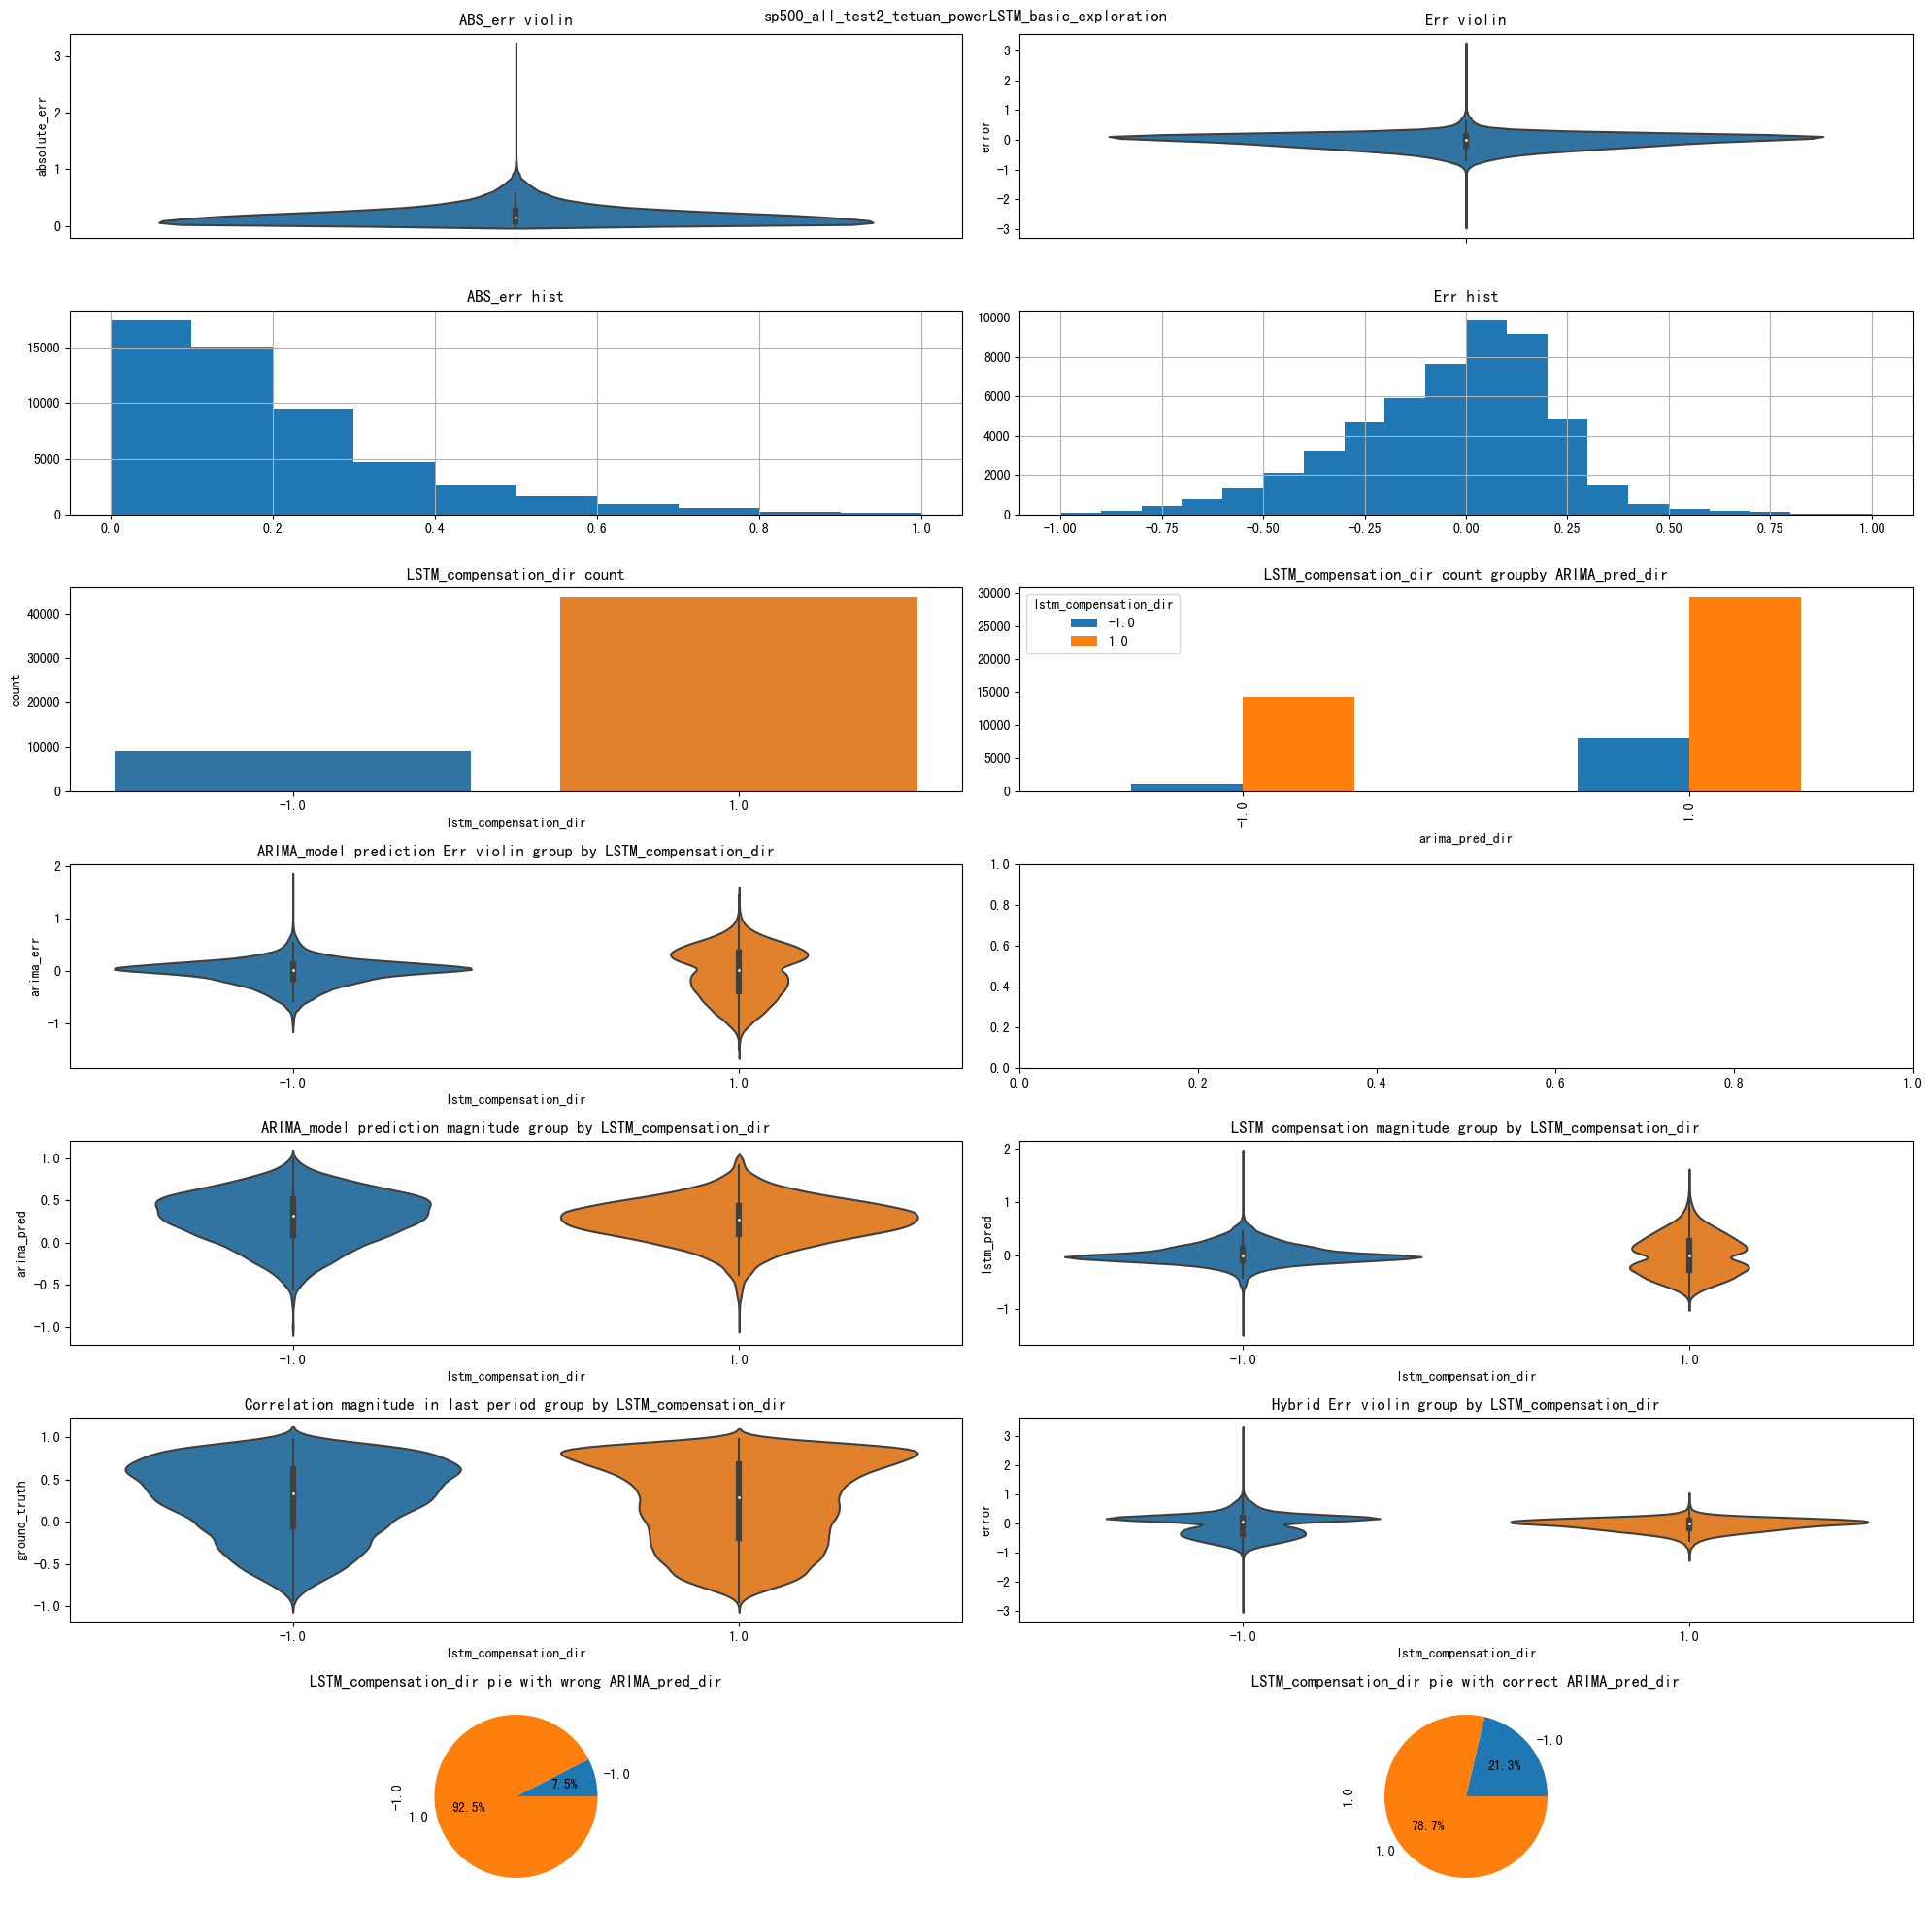

In [17]:
plot_exploration(res_df, fig_title)

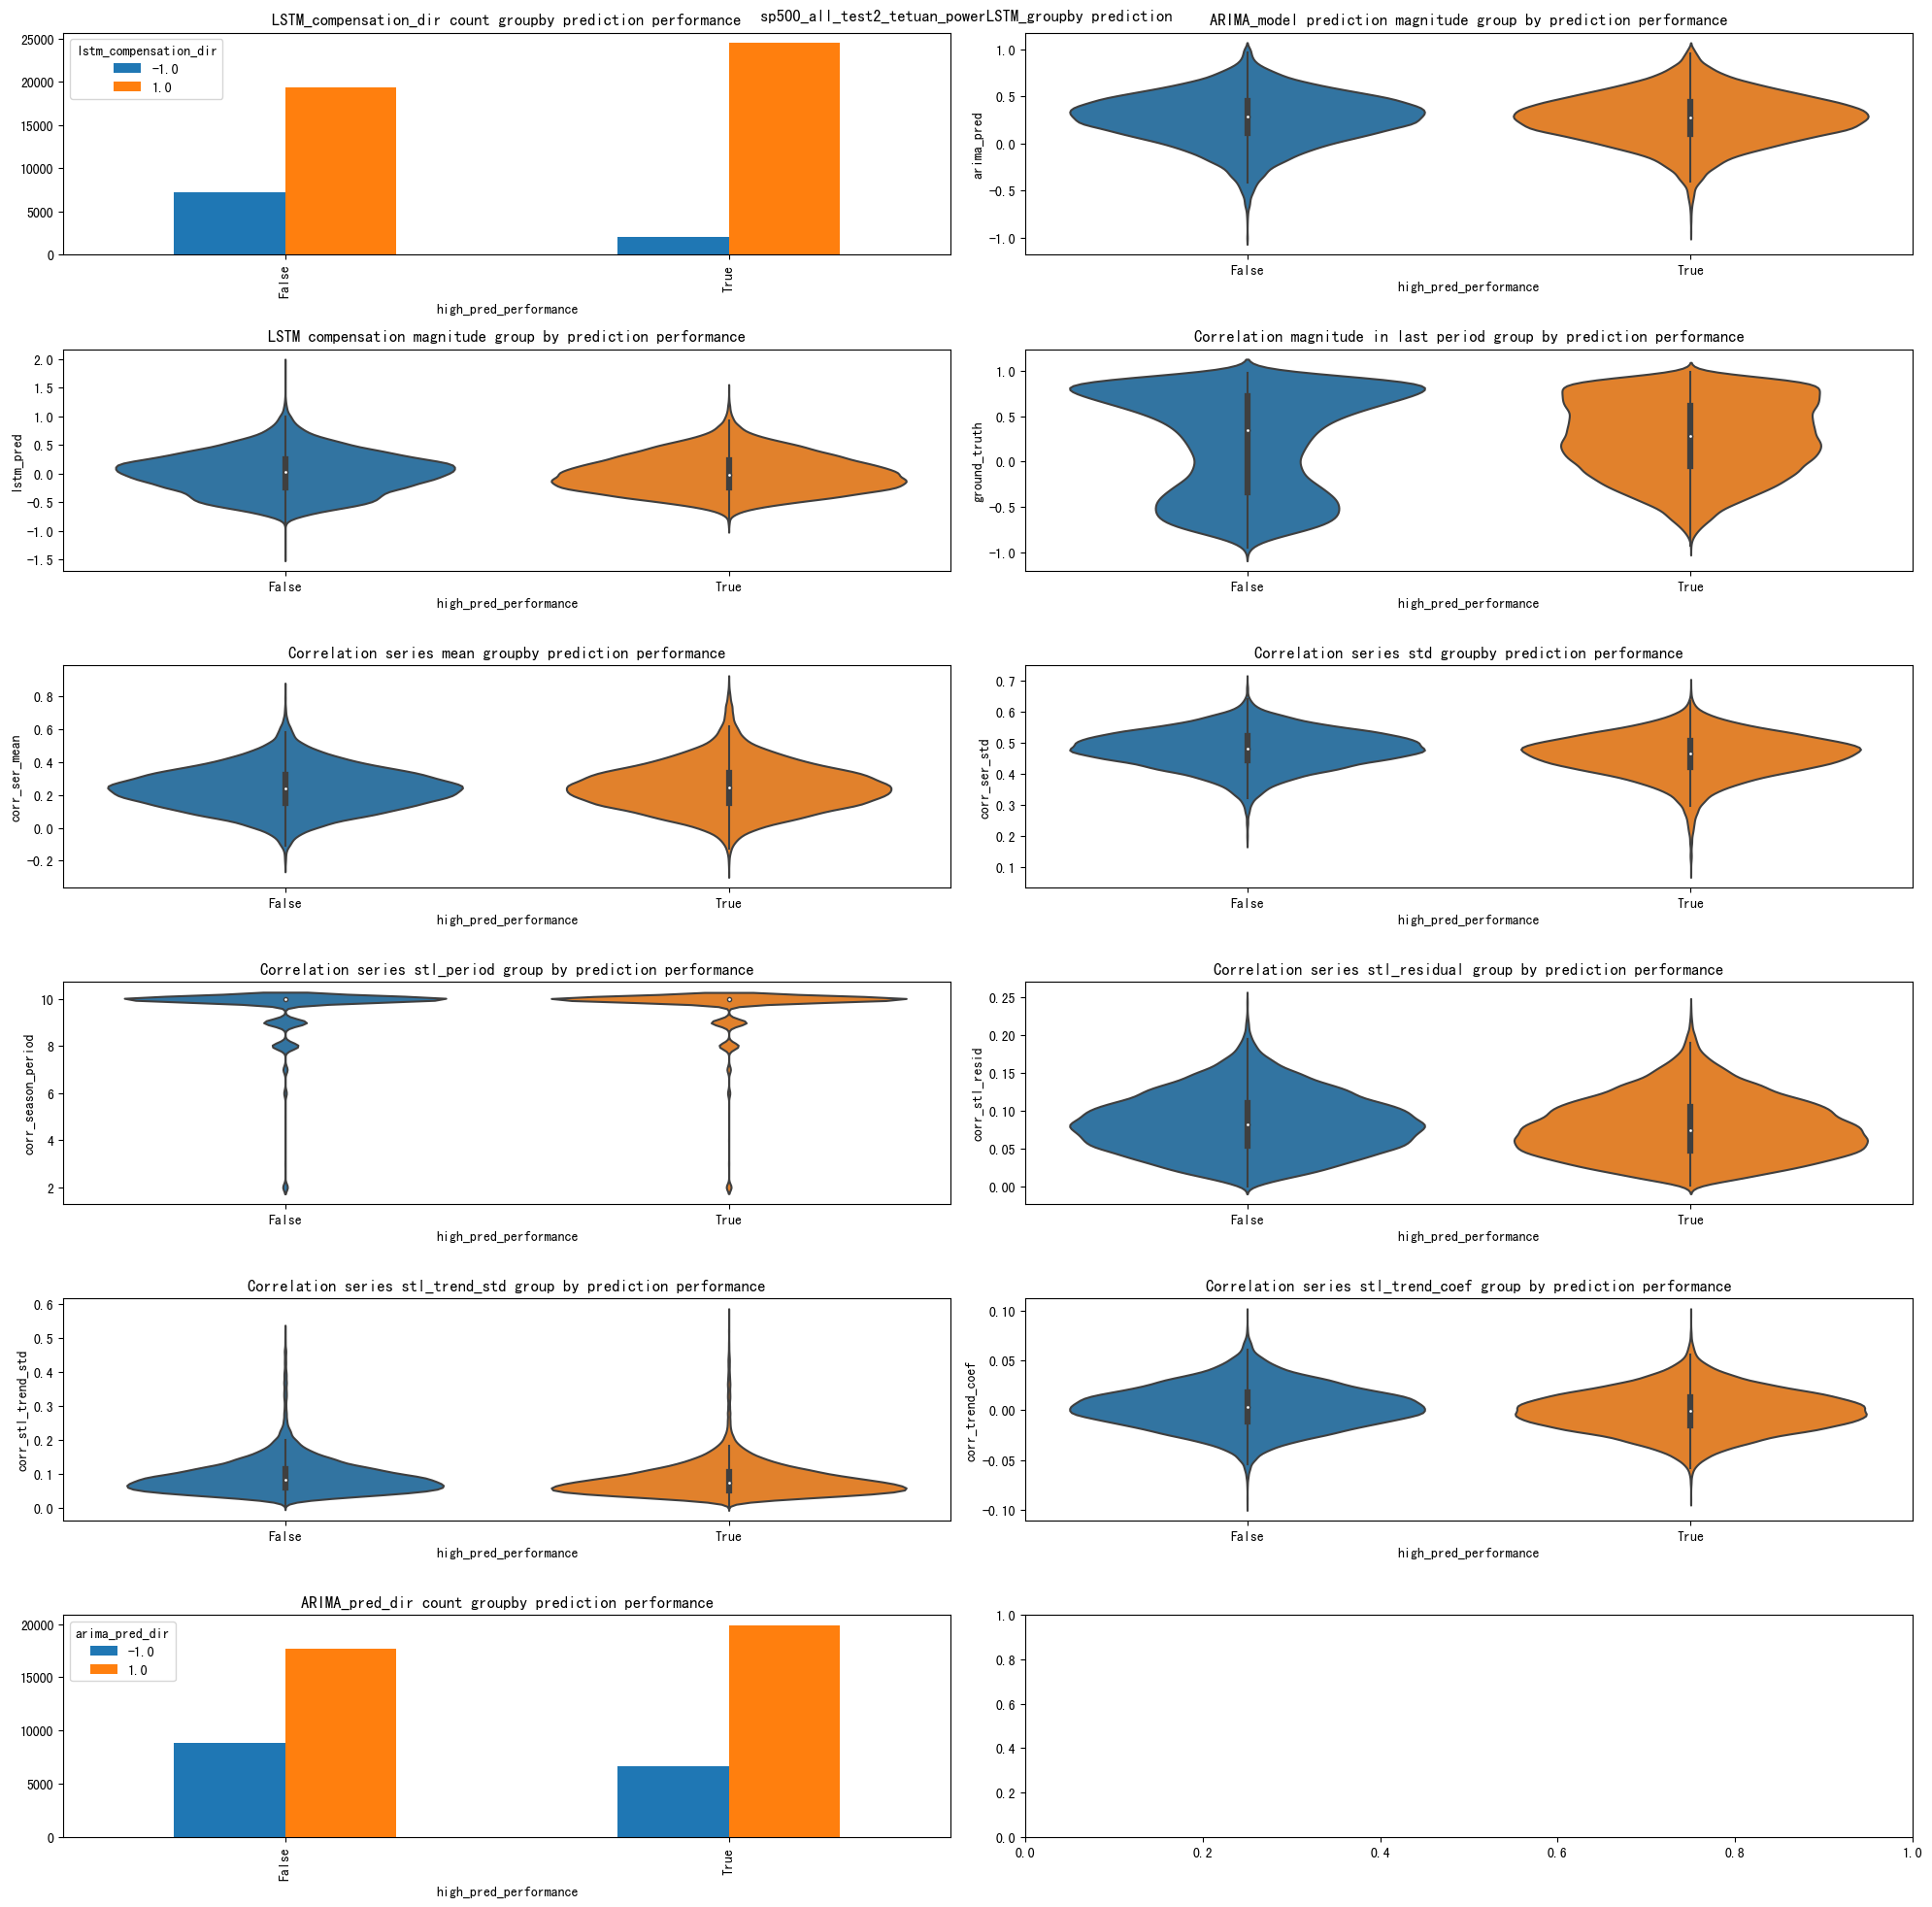

In [18]:
plot_exploration_pred_perform(res_df, fig_title)

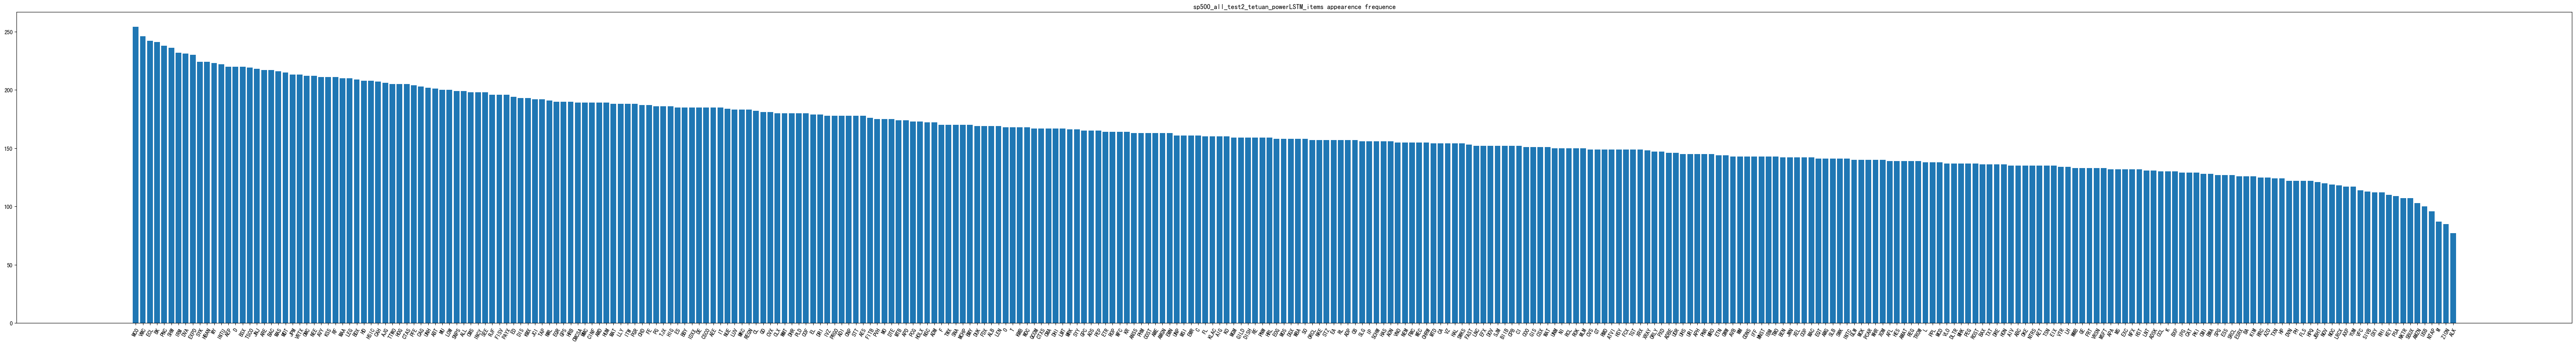

In [19]:
plot_stock_freq(res_df, fig_title)